In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Load Dataset
df = pd.read_csv("features_30_sec.csv")

#reading the data
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [2]:
#to know the name of the columns
df.columns

Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

In [3]:
# Feature Selection
features = [
    "chroma_stft_mean", "chroma_stft_var",
    "spectral_centroid_mean", "spectral_centroid_var",
    "spectral_bandwidth_mean", "spectral_bandwidth_var",
    "rolloff_mean", "rolloff_var",
    "zero_crossing_rate_mean", "zero_crossing_rate_var",
    "harmony_mean", "harmony_var",
    "perceptr_mean", "perceptr_var",
    "tempo"
]

# Add MFCC Features
mfcc_features = [f"mfcc{i}_mean" for i in range(1, 21)] + [f"mfcc{i}_var" for i in range(1, 21)]
features.extend(mfcc_features)

# Extract Features and Labels
X = df[features].values
y = df['label']

# Encode Labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [39]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Normalize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# TRAINING LSTM MODEL
# Reshape for LSTM (samples, timesteps=1, features)
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# Build LSTM Model
lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')  # 10 genres
])

# Compile Model
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train Model
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test), verbose=1)

# Predict Using LSTM
lstm_probs = lstm_model.predict(X_test_lstm)  # Probability outputs
lstm_preds = np.argmax(lstm_probs, axis=1)

# LSTM Accuracy
lstm_accuracy = accuracy_score(y_test, lstm_preds)
#print accuracy in percentage
print(f"LSTM Test Accuracy: {lstm_accuracy*100:.2f}%")


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - accuracy: 0.2116 - loss: 2.2829 - val_accuracy: 0.3200 - val_loss: 2.1861
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3345 - loss: 2.1188 - val_accuracy: 0.3550 - val_loss: 1.9014
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3656 - loss: 1.8249 - val_accuracy: 0.4250 - val_loss: 1.7062
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4497 - loss: 1.6042 - val_accuracy: 0.4700 - val_loss: 1.5205
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5048 - loss: 1.4275 - val_accuracy: 0.5150 - val_loss: 1.3734
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5546 - loss: 1.2905 - val_accuracy: 0.5700 - val_loss: 1.2560
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5500 - loss: 1.2305 - val_accuracy: 0.6300 - val_loss: 1.1753
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6554 - loss: 1.0563 - val_accuracy: 0.6150 - val_loss: 1.

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
LSTM Test Accuracy: 75.00%


In [36]:
# TRAINING SVM MODEL

svm_model = SVC(kernel='rbf', C=15, gamma='scale', probability=True)
svm_model.fit(X_train_scaled, y_train)

# Predict Using SVM
svm_probs = svm_model.predict_proba(X_test_scaled)  # Probability outputs
svm_preds = np.argmax(svm_probs, axis=1)

# SVM Accuracy
svm_accuracy = accuracy_score(y_test, svm_preds)
# Print Accuracy in percentage
print(f"SVM Test Accuracy: {svm_accuracy * 100:.2f}%")


SVM Test Accuracy: 76.00%


LSTM + SVM (Ensemble) Test Accuracy: 75.00% 
 



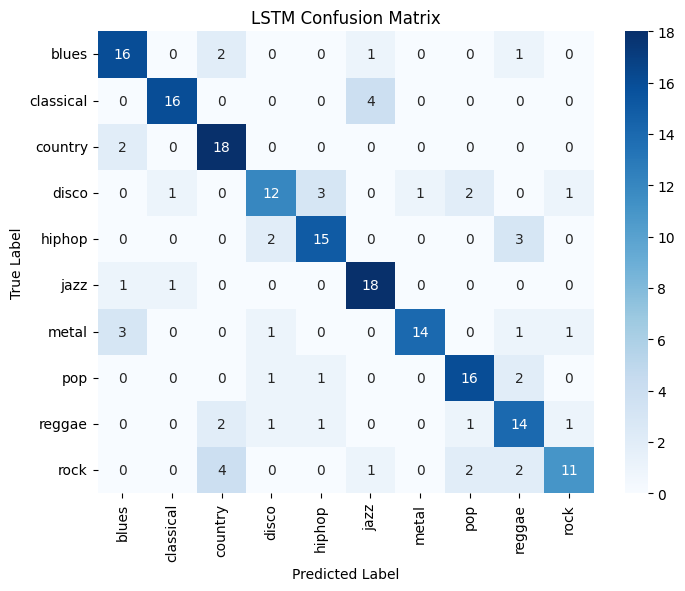

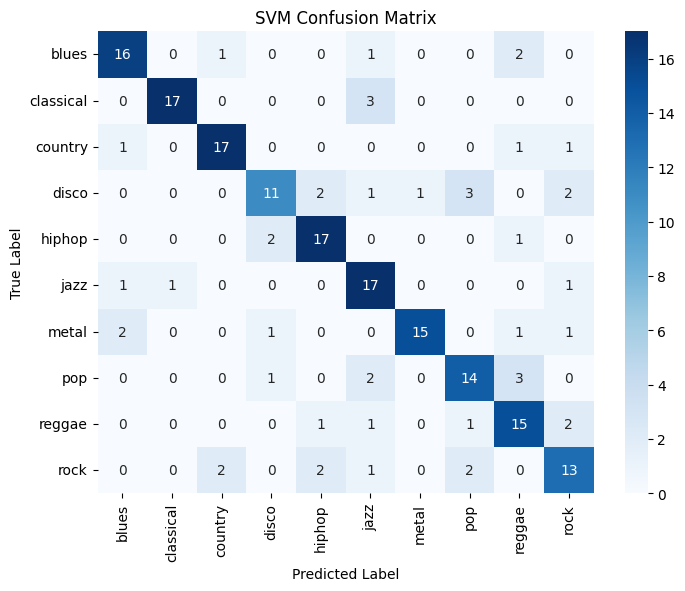

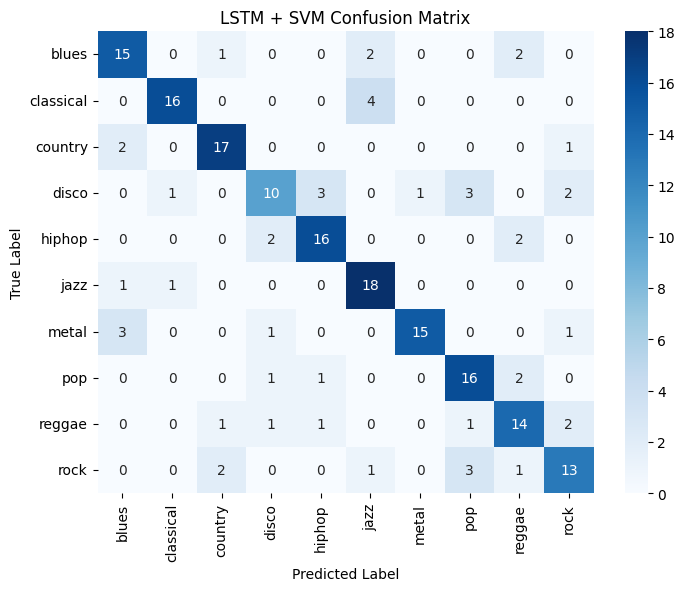

In [40]:
# ENSEMBLE: LSTM + SVM
# Average Probabilities
combined_probs = (lstm_probs + svm_probs) / 2

# Final Prediction (Argmax of Summed Probabilities)
ensemble_preds = np.argmax(combined_probs, axis=1)

# Ensemble Accuracy
ensemble_accuracy = accuracy_score(y_test, ensemble_preds)
print(f"LSTM + SVM (Ensemble) Test Accuracy: {ensemble_accuracy* 100:.2f}% \n \n")

# CONFUSION MATRIX FUNCTION
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

# Plot Confusion Matrices
plot_confusion_matrix(y_test, lstm_preds, "LSTM Confusion Matrix")
plot_confusion_matrix(y_test, svm_preds, "SVM Confusion Matrix")
plot_confusion_matrix(y_test, ensemble_preds, "LSTM + SVM Confusion Matrix")